### Mount drive to datasets:

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries and set `DATA_PATH`:

In [53]:
from pathlib import Path
import json
import glob
import numpy as np
import librosa
import os
from librosa import display
import matplotlib.pyplot as plt
from DLNet_functions import PreprocessWrapper
from models import ModelType, ModelBuilder
import tensorflow as tf
from time import strftime
assert tf.__version__ >= "2.0"
# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE
DATA_PATH = '/content/drive/MyDrive'

### All paths to possible codecs:
All codec datasets are created for a binary problem. <br>
See configs in DLNet_config.json for details.

In [63]:
# Path to datasets:
# AAC
path_aac_train = os.path.join(DATA_PATH, 'tf_dataset_aac_128', 'aac_128_train_set')
path_aac_test = os.path.join(DATA_PATH, 'tf_dataset_aac_128', 'aac_128_test_set')

# MP3 32k
path_mp3_32k_train = os.path.join(DATA_PATH, 'tf_dataset_mp3_32k', 'mp3_32k_train_set')
path_mp3_32k_test = os.path.join(DATA_PATH, 'tf_dataset_mp3_32k', 'mp3_32k_test_set')

# MP3 160k
path_mp3_160k_train = os.path.join(DATA_PATH, 'tf_dataset_mp3_160k', 'mp3_160k_train_set')
path_mp3_160k_test = os.path.join(DATA_PATH, 'tf_dataset_mp3_160k', 'mp3_160k_test_set')

# MP3 192k
path_mp3_192k_train = os.path.join(DATA_PATH, 'tf_dataset_mp3_192k', 'mp3_192k_train_set')
path_mp3_192k_test = os.path.join(DATA_PATH, 'tf_dataset_mp3_192k', 'mp3_192k_test_set')

# MP3 320k
path_mp3_320k_train = os.path.join(DATA_PATH, 'tf_dataset_mp3_320k', 'mp3_320k_train_set')
path_mp3_320k_test = os.path.join(DATA_PATH, 'tf_dataset_mp3_320k', 'mp3_320k_test_set')

# AC3
path_ogg_vbr_train = os.path.join(DATA_PATH, 'tf_dataset_ogg_vbr', 'ogg_vbr_train_set')
path_ogg_vbr_test = os.path.join(DATA_PATH, 'tf_dataset_ogg_vbr', 'ogg_vbr_test_set')

# Uncompressed/Lossless
path_uncompr_train = os.path.join(DATA_PATH, 'tf_dataset_uncompr_wav', 'uncompr_wav_train_set')
path_uncompr_test = os.path.join(DATA_PATH, 'tf_dataset_uncompr_wav', 'uncompr_wav_test_set')

### Choose two or more datasets to use for training and testing:

In [65]:
# Choose two codecs to compare:
path_codec1_train = path_ogg_vbr_train
path_codec1_test = path_ogg_vbr_test
path_codec2_train = path_uncompr_train
path_codec2_test = path_uncompr_test

### Read `config` and create `wrapper` object:
Each dataset has a config file included with the dataset configurations.<br>
Dataset configurations have to match to concatenate the datasets later.

In [66]:
 # Read configs from dataset:
json_file_codec1 =  os.path.join(os.path.split(path_codec1_train)[0], 'DLNet_config.json')
json_file_codec2 =  os.path.join(os.path.split(path_codec2_train)[0], 'DLNet_config.json')
with open(json_file_codec1, "r") as read_file:
            config1 = json.load(read_file)
with open(json_file_codec2, "r") as read_file:
            config2 = json.load(read_file)          
# Compare configs:
if not config1==config2:
  raise ValueError("Dataset have different config, codecs cannot be compared.") 
else:
  # Path to dataset_config:
  ds_config: str = os.path.join(DATA_PATH, 'dataset_config.json')
  # Creater wrapper object:
  wrapper: PreprocessWrapper = PreprocessWrapper(config1, ds_config)
  # Print Config:
  print(json.dumps(config1, sort_keys=False, indent=4))

{
    "audio_length": 1,
    "binary": true,
    "calculate_mel": false,
    "center": true,
    "classes": [
        "compressed_wav",
        "uncompr_wav"
    ],
    "filter_signal": false,
    "hop_length": 256,
    "input_shape": [
        513,
        173,
        1
    ],
    "mono": true,
    "n_fft": 1024,
    "n_frames": 173,
    "n_mels": 64,
    "pad_mode": "reflect",
    "power": 2.0,
    "random_seed": 10,
    "sr": 44100,
    "time_stamp": "14_02_2021_13_23",
    "win_length": 512,
    "window": "hamm"
}


### Load chosen datasets and concatenate them:

In [75]:
# Load dataset:
# Codec1: (Compressed)
train_codec1 = wrapper.load_tf_dataset(path_codec1_train)
test_codec1 = wrapper.load_tf_dataset(path_codec1_test)

# Codec2: (Uncompressed/Lossless)
train_codec2 = wrapper.load_tf_dataset(path_codec2_train)
test_codec2 = wrapper.load_tf_dataset(path_codec2_test)

# Concatenate datasets:
train_dataset = train_codec1.concatenate(train_codec2)
test_dataset = test_codec1.concatenate(test_codec2)


### Print dataset info:

In [76]:
print(train_codec1)
print(test_codec1)
print(train_codec2)
print(test_codec2)
print(train_dataset)
print(test_dataset)

<_LoadDataset shapes: ((513, 173, 1), (2,)), types: (tf.float32, tf.uint8)>
<_LoadDataset shapes: ((513, 173, 1), (2,)), types: (tf.float32, tf.uint8)>
<_LoadDataset shapes: ((513, 173, 1), (2,)), types: (tf.float32, tf.uint8)>
<_LoadDataset shapes: ((513, 173, 1), (2,)), types: (tf.float32, tf.uint8)>
<ConcatenateDataset shapes: ((513, 173, 1), (2,)), types: (tf.float32, tf.uint8)>
<ConcatenateDataset shapes: ((513, 173, 1), (2,)), types: (tf.float32, tf.uint8)>


### Prepare datasets:


*   Shuffle `train_dataset`
*   Take 10 % of `train_dataset` for evaluation: `eval_dataset`
*   Shuffle and batch rest of `train_dataset`
*   Batch `test_dataset`
*   Batch size: 64



In [77]:
train_size = len(train_dataset)
test_size = len(test_dataset)
eval_size = int(.1*train_size)
batch_size = 64

# Shuffel train data:
train_dataset = train_dataset.shuffle(buffer_size=train_size)

# Split train into train and eval set:
eval_dataset = train_dataset.take(eval_size)
eval_dataset = eval_dataset.batch(batch_size).prefetch(AUTOTUNE)

# Train dataset
train_dataset = train_dataset.skip(eval_size)
train_dataset = train_dataset.shuffle(train_size - eval_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(AUTOTUNE)

# Prepare test dataset
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)


### Load CNN Model:

In [78]:
MODEL_TYPE = ModelType.HENNEQUIN
model_builder = ModelBuilder(MODEL_TYPE, config['input_shape'],
                             config['classes'])
model = model_builder.get_model()

# Define metrics
metrics = [tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.FalseNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
           ]

### Compile, train and evaluate model:

In [79]:
# compile model
n_epochs = 20
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit model
history = model.fit(train_dataset, epochs=n_epochs,
                    validation_data=eval_dataset, verbose=1)

model.evaluate(test_dataset, batch_size=64)

Epoch 1/20
82/82 [==============================] - 53s 281ms/step - loss: 0.6942 - accuracy: 0.5017 - val_loss: 0.5946 - val_accuracy: 0.7638
Epoch 2/20
82/82 [==============================] - 37s 272ms/step - loss: 0.3933 - accuracy: 0.8294 - val_loss: 0.1019 - val_accuracy: 0.9586
Epoch 3/20
82/82 [==============================] - 37s 271ms/step - loss: 0.1497 - accuracy: 0.9372 - val_loss: 0.1050 - val_accuracy: 0.9621
Epoch 4/20
82/82 [==============================] - 37s 271ms/step - loss: 0.1023 - accuracy: 0.9639 - val_loss: 0.0508 - val_accuracy: 0.9845
Epoch 5/20
82/82 [==============================] - 37s 272ms/step - loss: 0.0858 - accuracy: 0.9672 - val_loss: 0.1250 - val_accuracy: 0.9431
Epoch 6/20
82/82 [==============================] - 37s 268ms/step - loss: 0.0660 - accuracy: 0.9783 - val_loss: 0.0538 - val_accuracy: 0.9845
Epoch 7/20
82/82 [==============================] - 37s 272ms/step - loss: 0.0546 - accuracy: 0.9811 - val_loss: 0.1883 - val_accuracy: 0.9224

[0.1836613118648529, 0.9573333263397217]

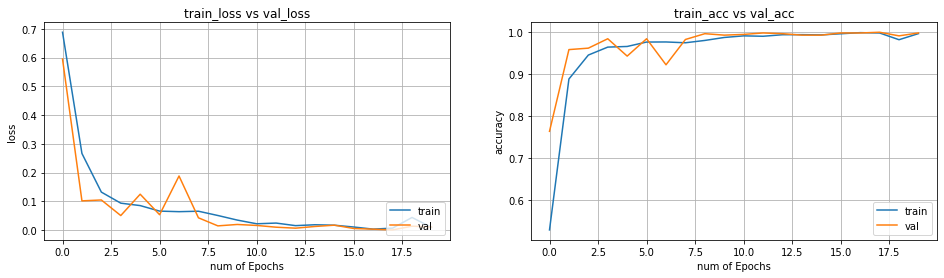

In [82]:
# setup plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,4))

# plot loss
ax[0].plot(range(n_epochs), history.history['loss'])
ax[0].plot(range(n_epochs), history.history['val_loss'])
ax[0].set_ylabel('loss'), ax[0].set_title('train_loss vs val_loss')

# plot accuracy
ax[1].plot(range(n_epochs), history.history['accuracy'])
ax[1].plot(range(n_epochs), history.history['val_accuracy'])
ax[1].set_ylabel('accuracy'), ax[1].set_title('train_acc vs val_acc')

# plot adjustement
for a in ax:
    a.grid(True)
    a.legend(['train','val'], loc=4)
    a.set_xlabel('num of Epochs')
plt.show()
